In [7]:
import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np
from pathlib import Path
from PIL import Image
import torch
import sys
import os
import math
sys.path.append("..")
sys.path.append('../scripts/')
from query_res import *
import pickle

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/T7/ILSVRC/Data/DET/val'

In [ ]:
"""
Built indexes of size 16 (1258 indexes)
    Index add time: 16.76579, 0.01333 per index
    Build time: 7.51236, 0.00597 per index
    CPU build time: 18.18460, 0.01446 per index

Built indexes of size 64 (315 indexes)
    Index add time: 15.09311, 0.04791 per index
    Build time: 1.67339, 0.00531 per index
    CPU build time: 4.66592, 0.01481 per index

Built indexes of size 128 (158 indexes)
    Index add time: 14.76481, 0.09345 per index
    Build time: 0.88575, 0.00561 per index
    CPU build time: 2.59277, 0.01641 per index

Built indexes of size 512 (40 indexes)
    Index add time: 14.01600, 0.35040 per index
    Build time: 0.21929, 0.00548 per index
    CPU build time: 0.81992, 0.02050 per index

Built indexes of size 1024 (20 indexes)
    Index add time: 13.96358, 0.69818 per index
    Build time: 6.54531, 0.32727 per index
    CPU build time: 44.62623, 2.23131 per index

Built indexes of size 4096 (5 indexes)
    Index add time: 14.04538, 2.80908 per index
    Build time: 13.36107, 2.67221 per index
    CPU build time: 86.67032, 17.33406 per index

Built indexes of size 8192 (3 indexes)
    Index add time: 14.58335, 4.86112 per index
    Build time: 14.45715, 4.81905 per index
    CPU build time: 100.21969, 33.40656 per index

Built indexes of size 20120 (1 indexes)
    Index add time: 13.83542, 13.83542 per index
    Build time: 23.69565, 23.69565 per index
    CPU build time: 157.91386, 157.91386 per index
""";

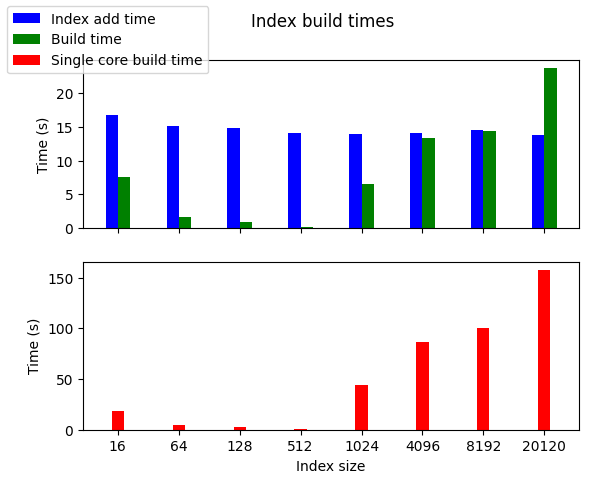

In [385]:
index_sizes = [16, 64, 128, 512, 1024, 4096, 8192, 20120]
index_add_times = [16.76579, 15.09311, 14.76481, 14.01600, 13.96358, 14.04538, 14.58335, 13.83542]
build_times = [7.51236, 1.67339, 0.88575, 0.21929, 6.54531, 13.36107, 14.45715, 23.69565]
cpu_build_times = [18.18460, 4.66592, 2.59277, 0.81992, 44.62623, 86.67032, 100.21969, 157.91386]
x = np.arange(len(index_sizes))

# https://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("Index build times")
ax = axs[0]
ax.bar(x - 0.1, index_add_times, width=0.2, color='b', align='center')
ax.bar(x + 0.1, build_times, width=0.2, color='g', align='center')
ax.set_ylabel("Time (s)")

ax = axs[1]
ax.bar(x, cpu_build_times, width=0.2, color='r', align='center')
ax.set_xticks(x, index_sizes)
ax.set_xlabel("Index size")
ax.set_ylabel("Time (s)")

fig.legend(('Index add time', 'Build time', 'Single core build time'), loc='upper left')
plt.show()
fig.savefig("../assets/images/index_build_times.png")

In [8]:
import pickle
imagewise_queries = pickle.load(open("../assets/pickles/imagewise_ann_queries_top5.pkl", "rb"))
querywise_queries = pickle.load(open("../assets/pickles/querywise_ann_queries_top5.pkl", "rb"))

In [572]:
imagewise_queries[20120][:20]

[[AnnoyImage(query='car', dist=1.0219215154647827, image_id=0, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00036091.JPEG'), imagenet_classes=None, index_id=0, ref_id=0)],
 [],
 [],
 [AnnoyImage(query='burrito', dist=1.0974313020706177, image_id=3, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2013_val_00001394.JPEG'), imagenet_classes=None, index_id=0, ref_id=3)],
 [],
 [],
 [AnnoyImage(query='banana', dist=0.9519601464271545, image_id=6, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00022482.JPEG'), imagenet_classes=None, index_id=0, ref_id=6),
  AnnoyImage(query='snake', dist=1.0022739171981812, image_id=6, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00022482.JPEG'), imagenet_classes=None, index_id=0, ref_id=6),
  AnnoyImage(query='centipede', dist=1.149985909461975, image_id=6, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00022482.JPEG'), imagenet_classes=None, index_id=0, 

In [14]:
image_dir = Path("/Volumes/T7/ILSVRC/Data/DET/val")
image_paths = [image_dir / file for file in os.listdir(image_dir)]

In [15]:
from clip_index.imagenet import ImagenetDETDataset

imagenet_root = Path("/Volumes/T7/ILSVRC/")
imagenet_synset = Path("../assets/imagenet_synset_det.txt")

dataset = ImagenetDETDataset(imagenet_root, imagenet_synset)

queries = [cls for cls in dataset._synset2desc.values()]


In [16]:
image_embeddings_motis = torch.load("../assets/tensors/image_embeddings.pt")
query_embeddings_motis = torch.load("../assets/tensors/query_embeddings.pt")

image_embeddings_base_32 = torch.load("../assets/tensors/image_embeddings_base_32.pt")
query_embeddings_base_32 = torch.load("../assets/tensors/query_embeddings_base_32.pt")

image_embeddings_motis.shape, query_embeddings_motis.shape, image_embeddings_base_32.shape, query_embeddings_base_32.shape

(torch.Size([20120, 512]),
 torch.Size([200, 512]),
 torch.Size([20120, 512]),
 torch.Size([200, 512]))

In [17]:
nimgs = len(image_paths)
correct_classes_imgs = [dataset.get_classes_from_image_path(image_paths[i]) for i in range(nimgs)]

In [286]:
i = 0
imagewise_queries[512][i], dataset.get_classes_from_image_path(image_paths[i])

([AnnoyImage(query='car', dist=1.0219215154647827, image_id=0, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00036091.JPEG'), imagenet_classes=None, index_id=0, ref_id=0),
  AnnoyImage(query='harmonica', dist=1.1797947883605957, image_id=0, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00036091.JPEG'), imagenet_classes=None, index_id=0, ref_id=0),
  AnnoyImage(query='lemon', dist=1.2336572408676147, image_id=0, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00036091.JPEG'), imagenet_classes=None, index_id=0, ref_id=0),
  AnnoyImage(query='cucumber', dist=1.248984694480896, image_id=0, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00036091.JPEG'), imagenet_classes=None, index_id=0, ref_id=0),
  AnnoyImage(query='sunglasses', dist=1.2565724849700928, image_id=0, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00036091.JPEG'), imagenet_classes=None, index_id=0, ref_id=0)],
 ['ca

In [18]:
def get_top1_top5_accuracy(index_size_queries: dict[int, ImagewiseResult], nimgs=len(image_paths)):
    top1_accuracys = []
    top5_accuracys = []
    for _, ann_queries in index_size_queries.items():
        # print(type(ann_queries))
        ann_queries = ann_queries.get('data', ann_queries)
        top_1_correct = 0
        top_5_correct = 0
        # Imagewise retrieval
        for i, ann_imgs in enumerate(ann_queries):
            if len(ann_imgs) == 0:
                continue

            correct_classes = correct_classes_imgs[i]
            
            if len(correct_classes) == 0:
                top_1_correct += 1
                top_5_correct += 1

            # TOP 1
            predicted_class = ann_imgs[0].query
            if predicted_class in correct_classes:
                top_1_correct += 1

            # TOP 5
            predicted_classes = [ann_img.query for ann_img in ann_imgs[:5]]
            if any([cls in correct_classes for cls in predicted_classes]):
                top_5_correct += 1

        top1_accuracy = top_1_correct / nimgs
        top5_accuracy = top_5_correct / nimgs
        top1_accuracys.append(top1_accuracy)
        top5_accuracys.append(top5_accuracy)
    return top1_accuracys, top5_accuracys

NameError: name 'ImagewiseResult' is not defined

In [397]:
# {max_results: {index_size: [[top 5 Annoy Images]]}}
# imagewise_max_results = pickle.load(open("../assets/pickles/imagewise_max_results_index_size.pkl", "rb"))
querywise_max_results_index_size = pickle.load(open("../assets/pickles/querywise_max_results_index_size.pkl", "rb"))

# Flat

In [13]:
flat_imagewise_results = pickle.load(open("../assets/pickles/imagewise_flat.pkl", "rb"))

In [ ]:
top1_noindex_accuracy = 0.566
top5_noindex_accuracy = 0.771
res_data = {k: v['data'] for k, v in flat_imagewise_results.items()}

In [15]:
top1_accuracys, top5_accuracys = get_top1_top5_accuracy(res_data)
print(top1_accuracys, top5_accuracys)
print(top1_noindex_accuracy, top5_noindex_accuracy)

[0.5224652087475149] [0.6986083499005964]
0.566 0.771


In [16]:
flat_stats = flat_imagewise_results[20120]['stats']
flat_stats

{'total_time': 651.9764960840039,
 'total_load_time': 0.054329916994902305,
 'total_query_time': 1.5636793431185652,
 'load_time_per_index': 0.054329916994902305,
 'query_time_per_query': 0.007818396715592826}

In [478]:
with open("../assets/pickles/querywise_flat_max_results.pkl", "rb") as f:
    flat_max_results = pickle.load(f)

In [479]:
stats_max_results_flat = {k: v[20120]['stats'] for k, v in flat_max_results.items()}


In [480]:
def listify_stats(stats):
    stats_titles = stats[list(stats.keys())[0]].keys()
    list_stats = {k: [] for k in stats_titles}
    for s in stats.values():
        for title in stats_titles:
            list_stats[title].append(s[title])
    return list_stats

In [481]:
stats = listify_stats(stats_max_results_flat)
max_results = [5, 10, 20, 50, 100, 200, 500, 1000]
x = np.arange(len(max_results))
stats.keys()

dict_keys(['total_time', 'total_load_time', 'total_query_time', 'load_time_per_index', 'query_time_per_query'])

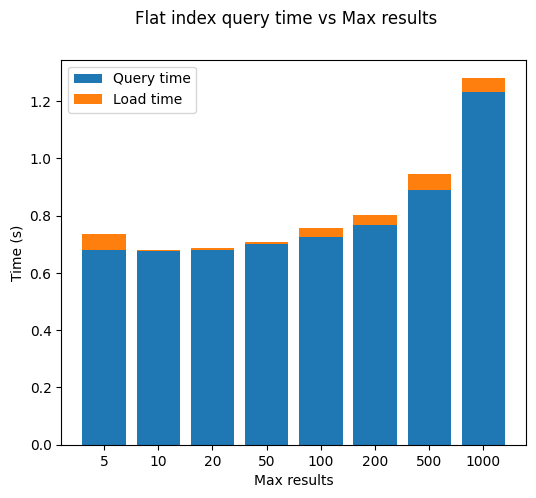

In [482]:

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.bar(x, stats['total_query_time'], label='Query time')
ax.set_xticks(x, max_results)

ax.bar(x, stats['total_load_time'], bottom=stats['total_query_time'], label='Load time')
ax.set_xlabel("Max results")
ax.set_ylabel("Time (s)")
fig.suptitle("Flat index query time vs Max results")
plt.legend()
plt.show()
fig.savefig("../assets/images/flat_query_time_vs_max_results.png")

In [483]:
stats['total_query_time']

[0.6817737080200459,
 0.6749241620927933,
 0.6804193740026676,
 0.7001564659585711,
 0.7254342979649664,
 0.7686878690074082,
 0.8910515009702067,
 1.232556707036565]

## Max results annoyh

In [398]:
querywise_max_results_index_size[1000][512]['stats']
# {max_results: {index_size: {stats}}}
stats_querywise_results = {maxr: {k: v['stats'] for k, v in res.items()} for maxr, res in querywise_max_results_index_size.items()}

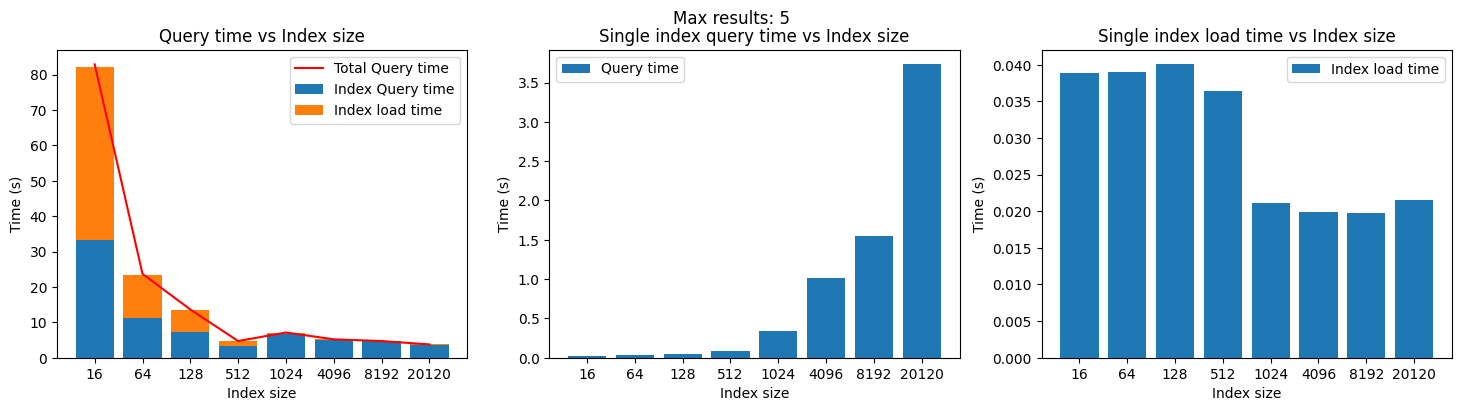

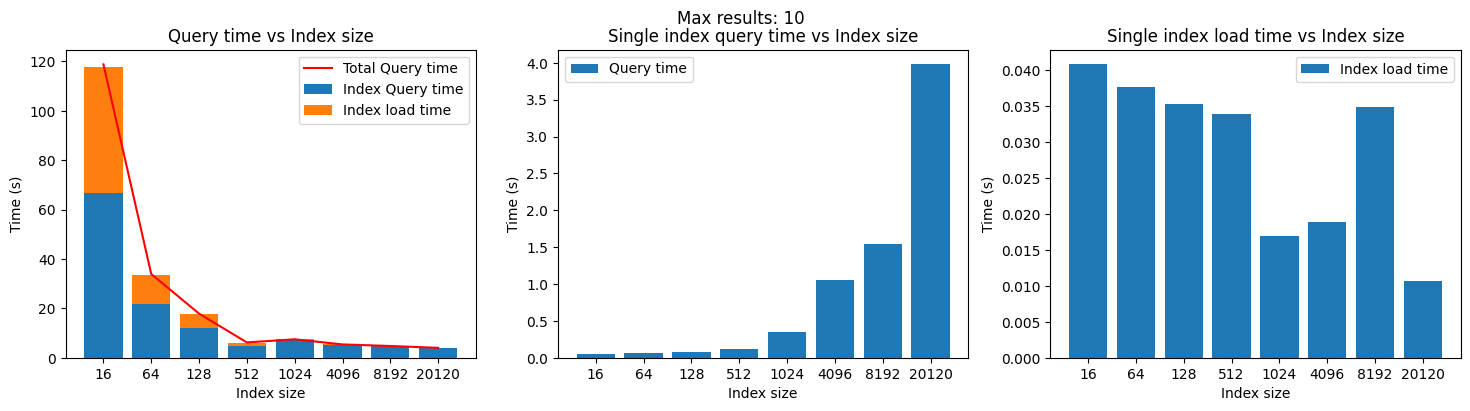

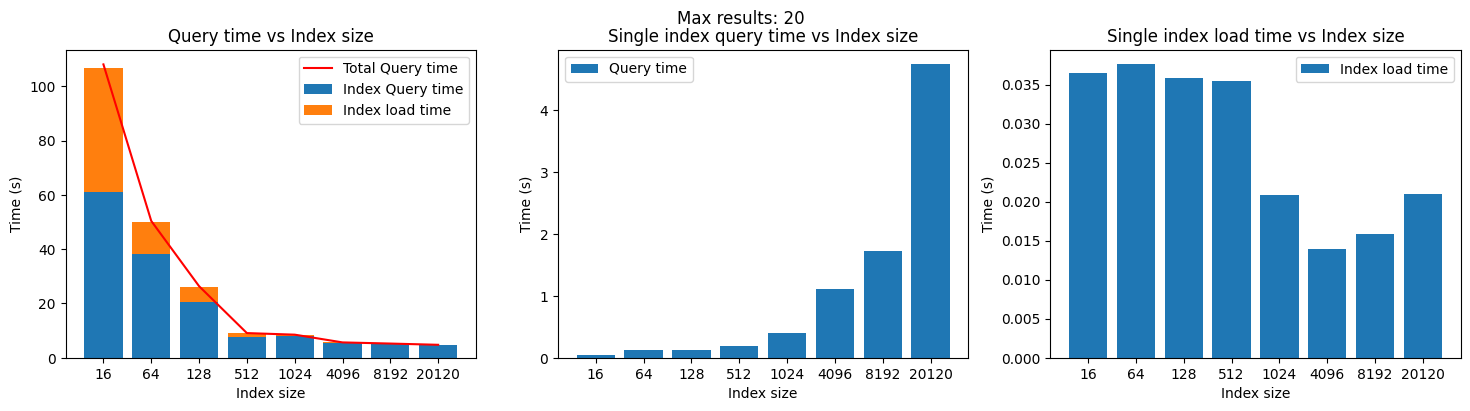

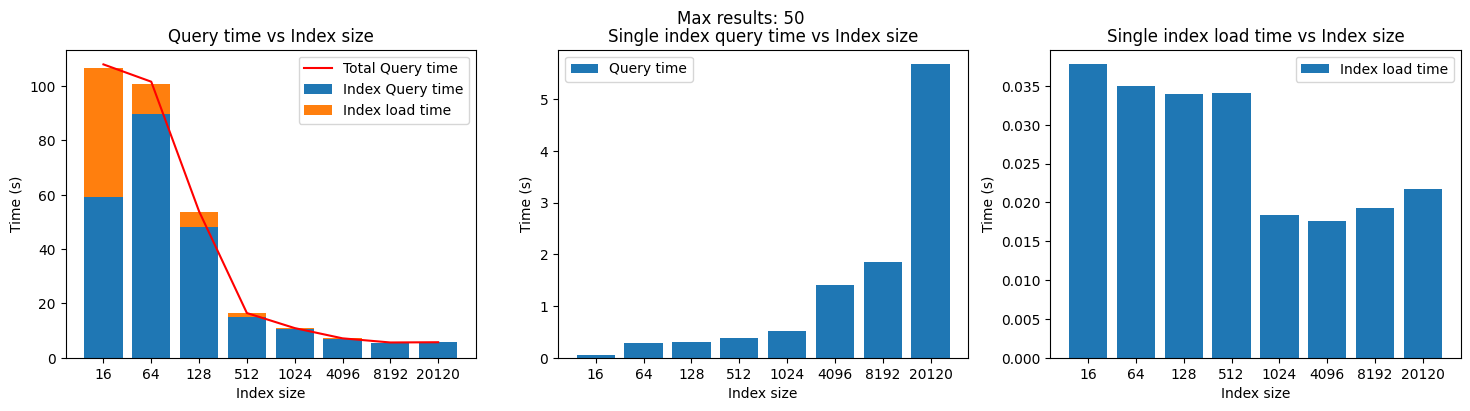

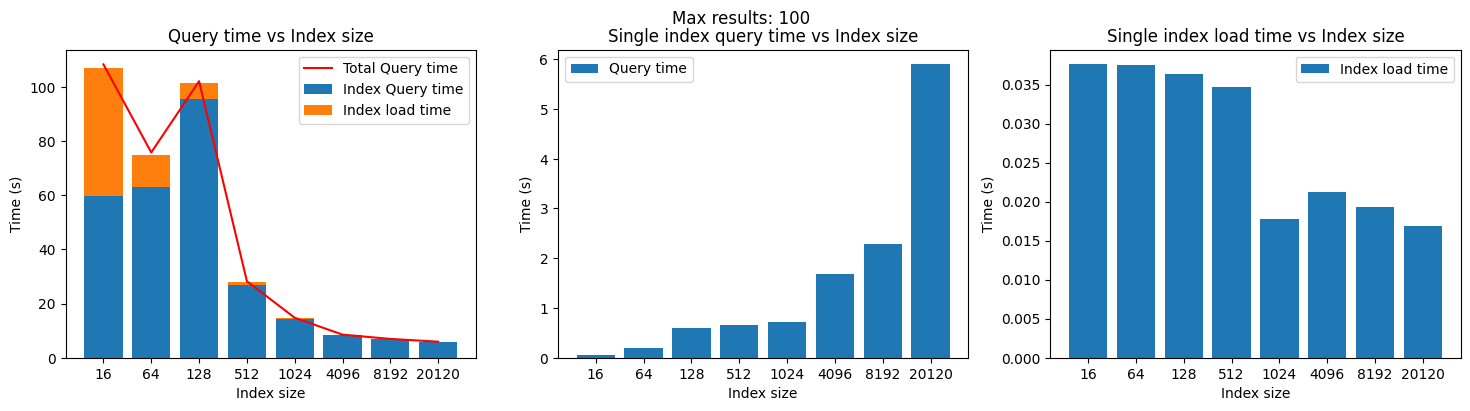

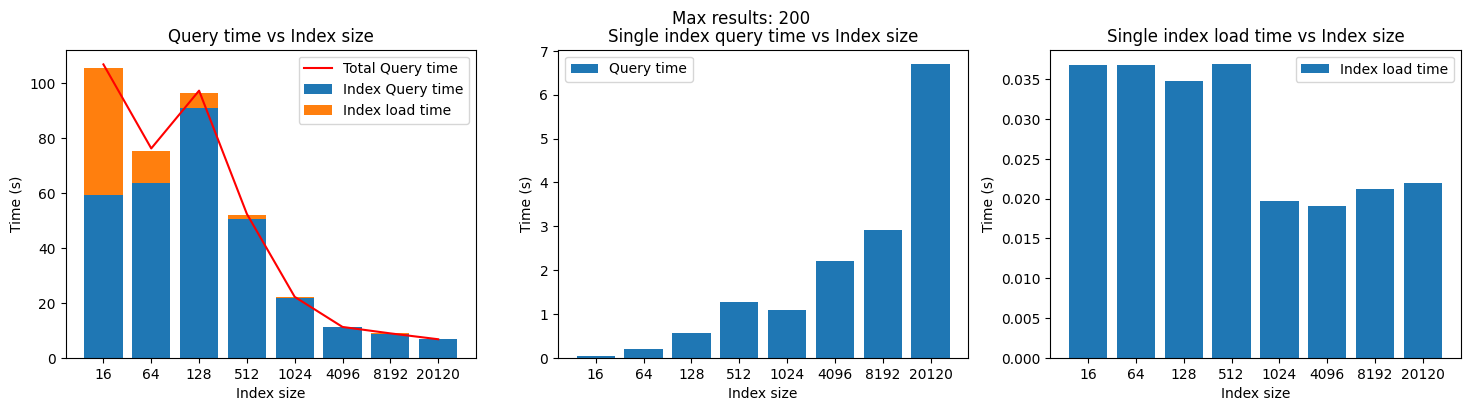

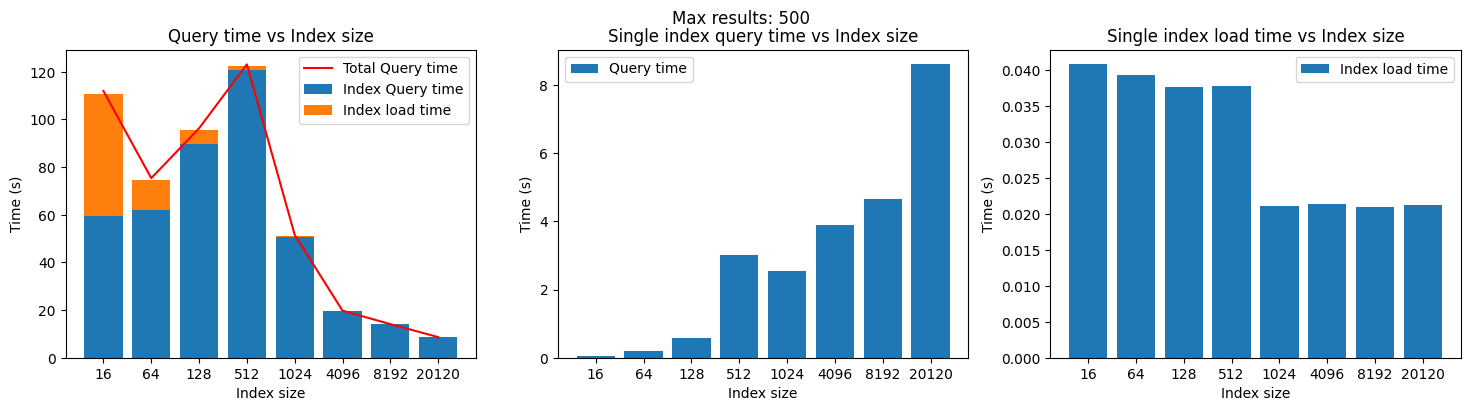

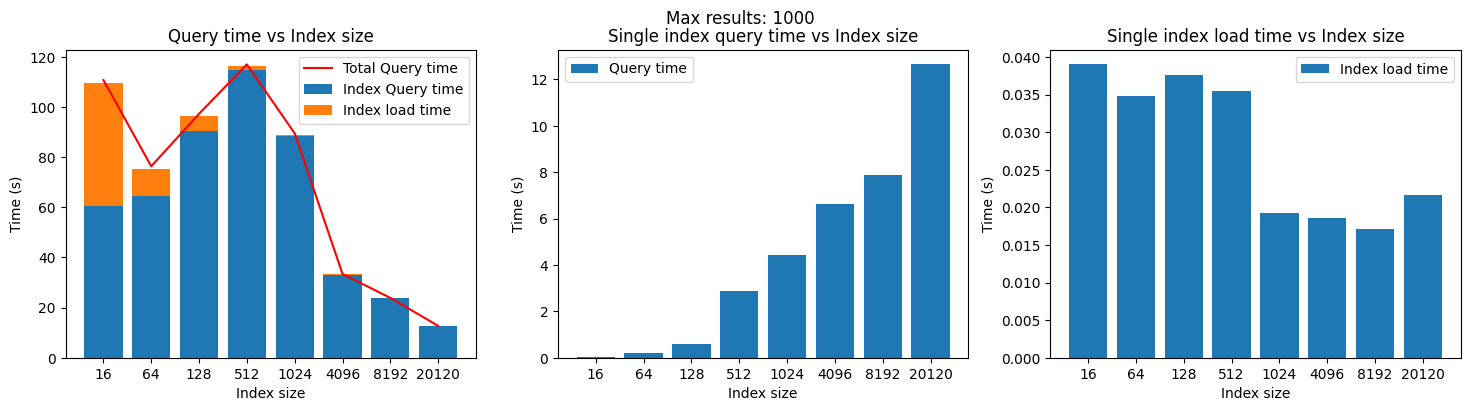

In [390]:
x = np.arange(len(index_sizes))
# max_results = [1000]

number_of_indexes = [math.ceil(20120/x) for x in index_sizes]

for i, maxr in enumerate(max_results):
    fig, (ax6, ax1, ax4) = plt.subplots(1, 3, figsize=(18, 4))

    res = stats_querywise_results[maxr]
    stats = listify_stats(res)
    time_to_query_single_index = list(map(lambda x, y: x/y, stats["total_query_time"], number_of_indexes))

    ax6.plot(x, stats["total_time"], label="Total Query time", color='r')
    ax6.bar(x, stats["total_query_time"], label="Index Query time")
    ax6.bar(x, stats["total_load_time"], bottom=stats["total_query_time"], label="Index load time")

    ax1.bar(x, time_to_query_single_index, label="Query time")

    ax4.bar(x, stats["load_time_per_index"], label="Index load time")

    ax6.set_title("Query time vs Index size")
    ax6.set_xticks(x, index_sizes)
    ax6.set_xlabel("Index size")
    ax6.set_ylabel("Time (s)")
    ax6.legend()

    ax1.set_title("Single index query time vs Index size")
    ax1.set_xticks(x, index_sizes)
    ax1.set_xlabel("Index size")
    ax1.set_ylabel("Time (s)")
    ax1.legend()


    ax4.set_title("Single index load time vs Index size")
    ax4.set_xticks(x, index_sizes)
    ax4.set_xlabel("Index size")
    ax4.set_ylabel("Time (s)")
    ax4.legend()
    
    fig.suptitle(f"Max results: {maxr}")

# fig.savefig("../assets/images/query_time_vs_index_size.png")
plt.show()
# NOTE: Single index load time is not related to max_results

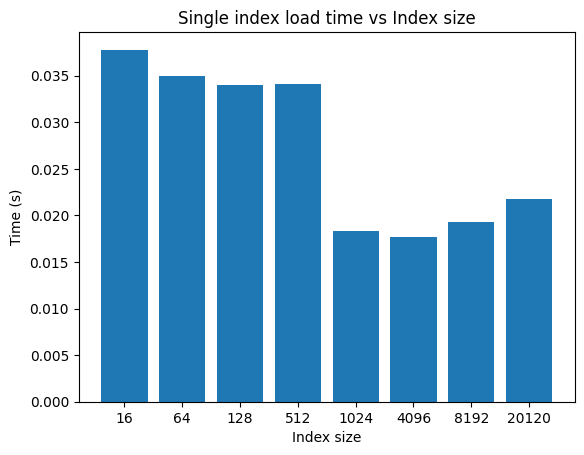

In [410]:
fig, ax = plt.subplots()
res = stats_querywise_results[50]
stats = listify_stats(res)
ax.bar(x, stats["load_time_per_index"], label="Index load time")
ax.set_xticks(x, index_sizes)
plt.ylabel("Time (s)")
plt.xlabel("Index size")
plt.title("Single index load time vs Index size")
plt.show()
fig.savefig("../assets/images/load_time_per_index.png")

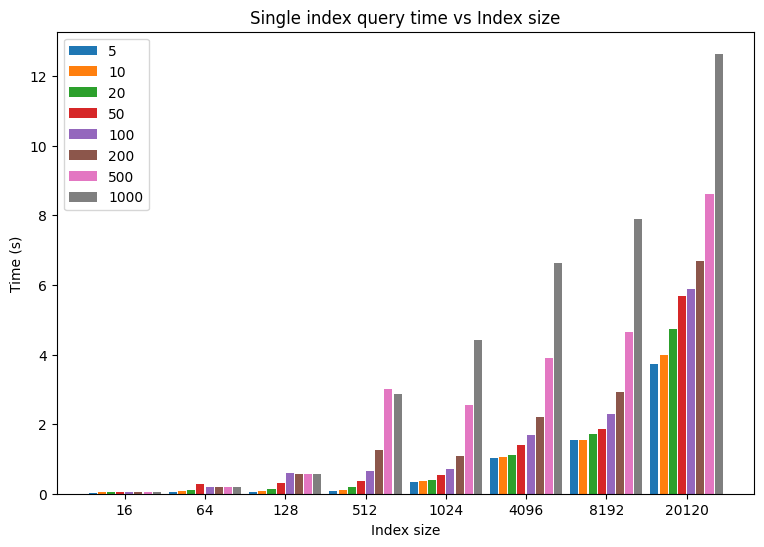

In [401]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
x = np.arange(len(index_sizes))
max_res_pos = np.linspace(-0.4, 0.4, len(max_results))

for i, maxr in enumerate(max_results):
    res = stats_imagewise_results[maxr]
    stats = listify_stats(res)
    time_to_query_single_index = list(map(lambda x, y: x/y, stats["total_query_time"], number_of_indexes))
    ax.bar(x + max_res_pos[i], time_to_query_single_index, width=0.1, label=maxr)

ax.set_title("Single index query time vs Index size")
ax.set_xticks(x, index_sizes)
ax.set_xlabel("Index size")
ax.set_ylabel("Time (s)")
ax.legend()

plt.savefig("../assets/images/single_index_query_time_vs_index_size.png")
plt.show()

What's interesting is that the max results that is ~= has the longest index time if it is slightly less than the index size.
This could be because for the max res 500 and index size 512 it still has to do a search, but with max res 1000 and index size 512 it can just return all the results

[109.38775051341509,
 75.38607883121585,
 96.41007240631734,
 116.15578180999728,
 88.67643169526127,
 33.186778890376445,
 23.72957119718194,
 12.666684413998155]

In [467]:
stats['total_load_time']

[49.08302281881333,
 10.96237333022873,
 5.937121575814672,
 1.418553959025303,
 0.3861111239530146,
 0.09305466699879616,
 0.05137070899945684,
 0.021602624998195097]

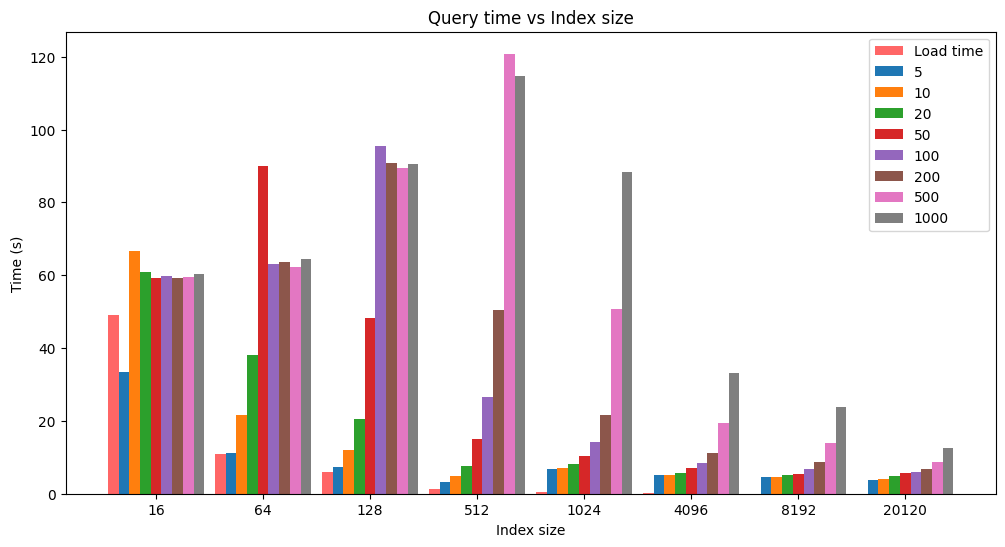

In [458]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
x = np.arange(len(index_sizes))
max_res_pos = np.linspace(-0.4, 0.4, len(max_results) + 1)

load_stats = listify_stats(stats_querywise_results[10])
ax.bar(x + max_res_pos[0], load_stats['total_load_time'], width=0.1, color='r', alpha=0.6, label="Load time")
for i, maxr in enumerate(max_results):
    res = stats_querywise_results[maxr]
    stats = listify_stats(res)
    ax.bar(x + max_res_pos[i+1], stats['total_query_time'], width=0.1, label=maxr)


ax.set_title("Query time vs Index size")
ax.set_xticks(x, index_sizes)
ax.set_xlabel("Index size")
ax.set_ylabel("Time (s)")
ax.legend()

plt.savefig("../assets/images/query_time_vs_index_size.png")
# What's interesting is that the max results that is ~= has the longest index time if it is slightly less than the index size.
# This could be because for the max res 500 and index size 512 it still has to do a search, but with max res 1000 and index size 512 it can just return all the results

In [476]:
[stats_querywise_results[maxr][20120]['total_query_time'] for maxr in max_results]

[3.731203539762646,
 3.978445419779746,
 4.736987038893858,
 5.676485335017787,
 5.89681617487804,
 6.690418708109064,
 8.612841575755738,
 12.64508178899996]

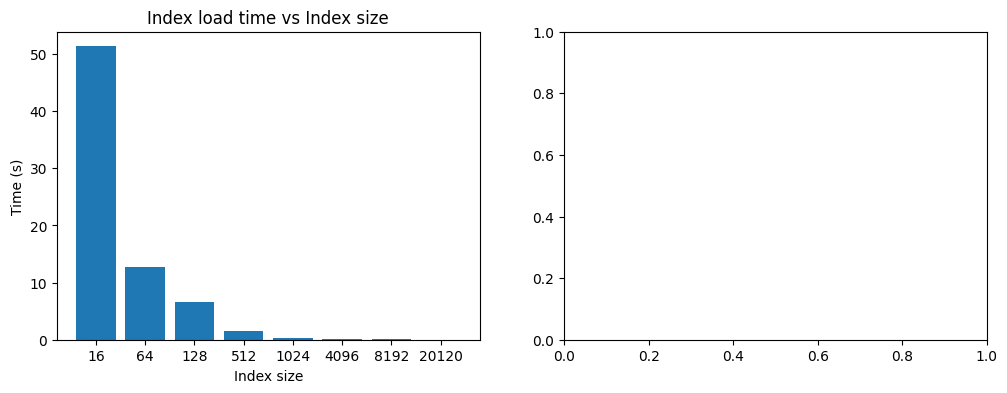

In [26]:
# TODO: Do against n_trees / search_k
# Sing index load time is constant -- more indexes => larger total index load time
fig, (ax6, ax1) = plt.subplots(1, 2, figsize=(12, 4))

res = stats_querywise_results[5]
stats = listify_stats(res)

# This is using the last index_load_time atm
ax6.bar(x, stats["total_load_time"])

ax6.set_title("Index load time vs Index size")
ax6.set_xticks(x, index_sizes)
ax6.set_xlabel("Index size")
ax6.set_ylabel("Time (s)")

plt.show()

I believe Annoy starts to lazy load the indexes past the index size of 512, which is why the <= 512 indexes are slower to load and faster to query than the > 512 indexes.

---

> The total query time does not *exactly* equal the sum of the query time and index load time. This is because it also includes extra python overhead.

> The maximum results allowed by annoy is 1000?

## Query Time vs Index Size

Here, we can see index load time *per index* is constant.
- However smaller indexes require more indexes to be loaded, leading to a larger total load time.
- The most significant factor is of course the query time, which decreases as the index size increases, as expected.
- This is because a larger index holds more images, so requires less indexes to be queried.


## Time to query single index vs Index size

- Obviously this one is unfair since smaller indexes will obviously take less time than larger indexes.
- However, it is interesting that the time to query a single index is fairly constant up until 512, and then it starts to increase.
- However, the amount the index time increases by is less than the amount the total query time decreases by.

## Conclusions

Finally, it is interesting that the 512 index slightly outperforms the 1024 index in query time. 

Base CLIP model Vit-B/32

- Time to create image embeddings: 967.852 seconds -- not correct

Resnet50
- 2383.860 seconds

In [27]:
"""
Max results per query: 1
	Index size 512 took 0.35632 seconds
	Total load time: 0.01508 seconds, 0.01508 per index
	Total query time: 0.33506, 0.00168 per query

Max results per query: 5
	Index size 512 took 0.29982 seconds
	Total load time: 0.00014 seconds, 0.00014 per index
	Total query time: 0.29665, 0.00148 per query

Max results per query: 10
	Index size 512 took 0.33133 seconds
	Total load time: 0.00012 seconds, 0.00012 per index
	Total query time: 0.32628, 0.00163 per query

Max results per query: 20
	Index size 512 took 0.36495 seconds
	Total load time: 0.00015 seconds, 0.00015 per index
	Total query time: 0.35696, 0.00178 per query

Max results per query: 50
	Index size 512 took 0.52374 seconds
	Total load time: 0.00141 seconds, 0.00141 per index
	Total query time: 0.50243, 0.00251 per query

Max results per query: 100
	Index size 512 took 0.68212 seconds
	Total load time: 0.00017 seconds, 0.00017 per index
	Total query time: 0.65211, 0.00326 per query

Max results per query: 200
	Index size 512 took 1.11366 seconds
	Total load time: 0.00014 seconds, 0.00014 per index
	Total query time: 1.05386, 0.00527 per query

Max results per query: 500
	Index size 512 took 2.34296 seconds
	Total load time: 0.00014 seconds, 0.00014 per index
	Total query time: 2.22419, 0.01112 per query

Max results per query: 1000
	Index size 512 took 4.47010 seconds
	Total load time: 0.00029 seconds, 0.00029 per index
	Total query time: 4.26663, 0.02133 per query
""";

In [28]:
max_results_512 = [1, 5, 10, 20, 50, 100, 200, 500]
max_results_1024 = [1, 5, 10, 20, 50, 100, 200, 500, 1000]

time_per_query_1024 = [0.33506, 0.29665, 0.32628, 0.35696, 0.50243, 0.65211, 1.05386, 2.22419, 4.26663]
time_per_query_512 = [0.20996, 0.20204, 0.23592, 0.31013, 0.49875, 0.78132, 1.34248, 3.04603]

# Change these
max_results = max_results_512
time_per_query = time_per_query_512
nimgs = 512
max_results_res = pickle.load(open("../assets/pickles/max_results_res_512.pkl", "rb"))
plt_path = "../assets/images/max_results_512.png"

assert len(max_results) == len(time_per_query), f"{len(max_results)} != {len(time_per_query)}"

In [29]:
(
    top_1_accuracies_max_results_all,
    top_5_accuracies_max_results_all,
) = get_top1_top5_accuracy(max_results_res, nimgs=nimgs)


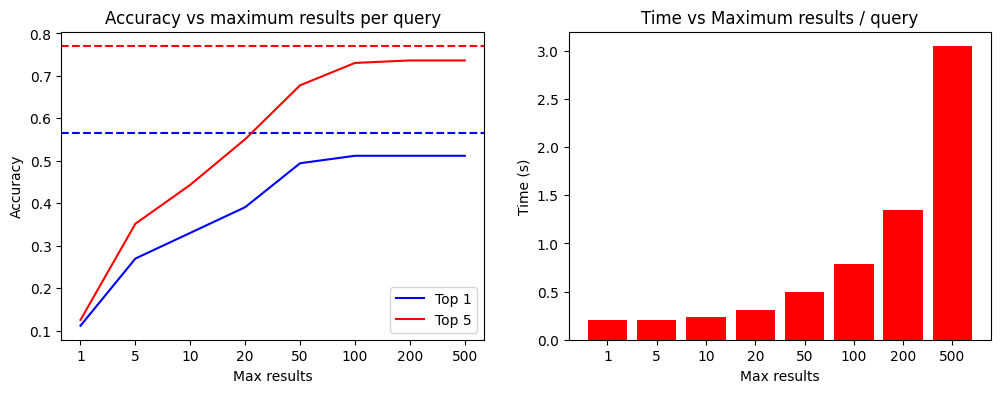

In [30]:
x = np.arange(len(max_results))
fig, (ax6, ax1) = plt.subplots(1, 2, figsize=(12, 4))

ax6.plot(x, top_1_accuracies_max_results_all, label="Top 1", color='b')
ax6.axhline(y=top1_noindex_accuracy, linestyle='--', color='b')

ax6.plot(x, top_5_accuracies_max_results_all, label="Top 5", color='r')
ax6.axhline(y=top5_noindex_accuracy, linestyle='--', color='r')

ax6.set_xticks(x, max_results)
ax6.legend()
ax6.set_xlabel("Max results")
ax6.set_ylabel("Accuracy")
ax6.set_title("Accuracy vs maximum results per query")

ax1.bar(x, time_per_query, color='r')
ax1.set_title("Time vs Maximum results / query")
ax1.set_xticks(x, max_results)
ax1.set_xlabel("Max results")
ax1.set_ylabel("Time (s)")

fig.savefig(plt_path)
plt.show()

In [22]:
total_each_class = dataset.total_each_class("val")
total_dataset = dataset.get_num_images("val")
import pickle

querywise_queries = pickle.load(open("../assets/pickles/querywise_imagenet_classes_512.pkl", "rb"))
querywise_queries = pickle.load(open("../assets/pickles/querywise_flat_max_results.pkl", "rb"))

In [18]:
max_max = 0
ann_queries = querywise_queries[1000][20120]['data']
dataset.add_imagenet_classes_queries(ann_queries)

for q in ann_queries.keys():
    max_max = max(max_max, max(map(lambda x: x.dist, ann_queries[q])))
max_max

1.2617214053677746

In [19]:
flattened_images = [i for j in ann_queries.values() for i in j]

1000

In [19]:
from clip_index.stats import annoy_query_stats, QueryStats

import torch
# thresholds = torch.arange(0.95, 1.25, 0.01)
thresholds = torch.arange(0.9, 1.25, 0.01)

# thres_stats = torch.empty(len(querywise_queries), len(thresholds))
stats: list[list[QueryStats]] = []


for j, thres in enumerate(thresholds):
    qstats = []
    for q, imgs in ann_queries.items():
        thres_imgs = filter(lambda x: x.dist < thres, imgs)
        qstat = annoy_query_stats(q, thres_imgs, total_each_class[q], total_dataset)
        qstats.append(qstat)
    stats.append(qstats)

a = lambda x: [np.mean([x(qstat) for qstat in qstats]) for qstats in stats]

NameError: name 'ann_queries' is not defined

In [22]:
recalls = a(lambda x: x.recall())
precisions = a(lambda x: x.precision())
f1s = a(lambda x: x.f1())
accuracies = a(lambda x: x.accuracy())

false_pos_rate = list(map(lambda x: 1 - x, recalls))

In [3]:
from torch import Tensor
import torch
import numpy as np


with torch.no_grad():
    image_embeddings_motis = torch.load("../assets/tensors/image_embeddings.pt")
    query_embeddings_motis = torch.load("../assets/tensors/query_embeddings.pt")
    image_embeddings_motis /= torch.linalg.norm(image_embeddings_motis, dim=1, keepdim=True)
    query_embeddings_motis /= torch.linalg.norm(query_embeddings_motis, dim=1, keepdim=True)
    angular_distances_motis: Tensor = np.arccos(image_embeddings_motis @ query_embeddings_motis.T)

    image_embeddings_base_32 = torch.load("../assets/tensors/image_embeddings_base_32.pt")
    query_embeddings_base_32 = torch.load("../assets/tensors/query_embeddings_base_32.pt")
    image_embeddings_base_32 /= torch.linalg.norm(image_embeddings_base_32, dim=1, keepdim=True)
    query_embeddings_base_32 /= torch.linalg.norm(query_embeddings_base_32, dim=1, keepdim=True)
    angular_distances_base_32: Tensor = np.arccos(image_embeddings_base_32 @ query_embeddings_base_32.T)

    image_embeddings_resnet50 = torch.load("../assets/tensors/image_embeddings_resnet50.pt")
    query_embeddings_resnet50 = torch.load("../assets/tensors/query_embeddings_resnet50.pt")
    image_embeddings_resnet50 /= image_embeddings_resnet50.norm(dim=-1, keepdim=True)
    query_embeddings_resnet50 /= query_embeddings_resnet50.norm(dim=-1, keepdim=True)
    angular_distances_resnet50: Tensor = np.arccos(image_embeddings_resnet50 @ query_embeddings_resnet50.T)
    
    image_embeddings_large_14 = torch.load("../assets/tensors/image_embeddings_large_14.pt")
    query_embeddings_large_14 = torch.load("../assets/tensors/query_embeddings_large_14.pt")
    image_embeddings_large_14 /= image_embeddings_large_14.norm(dim=-1, keepdim=True)
    query_embeddings_large_14 /= query_embeddings_large_14.norm(dim=-1, keepdim=True)
    angular_distances_large_14: Tensor = np.arccos(image_embeddings_large_14 @ query_embeddings_large_14.T)
    
    image_embeddings_base_16 = torch.load("../assets/tensors/image_embeddings_base_16.pt")
    query_embeddings_base_16 = torch.load("../assets/tensors/query_embeddings_base_16.pt")
    image_embeddings_base_16 /= image_embeddings_base_16.norm(dim=-1, keepdim=True)
    query_embeddings_base_16 /= query_embeddings_base_16.norm(dim=-1, keepdim=True)
    angular_distances_base_16: Tensor = np.arccos(image_embeddings_base_16 @ query_embeddings_base_16.T)
    
    image_embeddings_resnet50x4 = torch.load("../assets/tensors/image_embeddings_rn50x4.pt")
    query_embeddings_resnet50x4 = torch.load("../assets/tensors/query_embeddings_rn50x4.pt")
    image_embeddings_resnet50x4 /= image_embeddings_resnet50x4.norm(dim=-1, keepdim=True)
    query_embeddings_resnet50x4 /= query_embeddings_resnet50x4.norm(dim=-1, keepdim=True)
    angular_distances_resnet50x4: Tensor = np.arccos(image_embeddings_resnet50x4 @ query_embeddings_resnet50x4.T)


query_ang_dists_motis = angular_distances_motis.T
query_ang_dists_base_32 = angular_distances_base_32.T
query_ang_dists_resnet50 = angular_distances_resnet50.T
query_ang_dists_large_14 = angular_distances_large_14.T
query_ang_dists_base_16 = angular_distances_base_16.T
query_ang_dists_resnet50x4 = angular_distances_resnet50x4.T

In [4]:
torch.where(query_ang_dists_motis[0] < 1.1), torch.where(query_ang_dists_base_32[0] < 1.3)

((tensor([ 2284, 13653]),),
 (tensor([   32,   219,  1265,  1325,  1964,  2284,  2687,  3161,  3797,  3882,
           3932,  4116,  4124,  4348,  4609,  4892,  6448,  6874,  7545,  7631,
           7873,  8022,  8508,  9047,  9081, 10141, 10218, 10740, 10876, 11775,
          12256, 12350, 12775, 13442, 13532, 13581, 14768, 14844, 15500, 16543,
          16616, 16853, 17527, 18360, 18885, 19363, 19388, 19816]),))

In [30]:
def precision_recall_f1(query_ang_dists):
    thresholds = torch.arange(0.9, 1.6, 0.01)
    precisions = []
    recalls = []
    f1s = []
    for k, thres in enumerate(thresholds):
        ps, rs, fs = [], [], []
        for q in range(200):
            inds = torch.where(query_ang_dists[q] < thres)[0]
            tp, fp = 0, 0
            for idx in inds:
                predicted_class = queries[q]
                if predicted_class in correct_classes_imgs[idx]: # or len(correct_classes_imgs[idx]) == 0:
                    tp += 1
                else:
                    fp += 1
            fn = total_each_class[queries[q]] - tp
            tn = total_dataset - tp - fp - fn
            if tp + fp == 0:
                precision = 1
            else:
                precision = tp / (tp + fp)
            if tp + fn == 0:
                recall = 0
            else:
                recall = tp / (tp + fn)
            f1 = 0 if precision + recall == 0 else 2 * (precision * recall) / (precision + recall)
            ps.append(precision)
            rs.append(recall)
            fs.append(f1)
        precisions.append(np.mean(ps))
        recalls.append(np.mean(rs))
        f1s.append(np.mean(fs))
    return precisions[:], recalls[:], f1s[:], thresholds[:]

precisions, recalls, f1s, thresholds = precision_recall_f1(query_ang_dists_motis)[:]
precisions_base_32, recalls_base_32, f1s_base_32, thresholds_base_32 = precision_recall_f1(query_ang_dists_base_32)[:]
precisions_resnet50, recalls_resnet50, f1s_resnet50, thresholds_resnet50 = precision_recall_f1(query_ang_dists_resnet50)[:]
precisions_large_14, recalls_large_14, f1s_large_14, thresholds_large_14 = precision_recall_f1(query_ang_dists_large_14)[:]
precisions_base_16, recalls_base_16, f1s_base_16, thresholds_base_16 = precision_recall_f1(query_ang_dists_base_16)[:]
precisions_resnet50x4, recalls_resnet50x4, f1s_resnet50x4, thresholds_resnet50x4 = precision_recall_f1(query_ang_dists_resnet50x4)[:]

In [25]:
total_each_class

{'person': 5791,
 'airplane': 61,
 'artichoke': 47,
 'table': 1290,
 'banjo': 42,
 'traffic light': 90,
 'dog': 2993,
 'fox': 119,
 'hamburger': 49,
 'bow tie': 71,
 'skunk': 47,
 'bird': 2209,
 'watercraft': 442,
 'microphone': 217,
 'guitar': 141,
 'bowl': 454,
 'tiger': 37,
 'pitcher': 88,
 'pomegranate': 46,
 'swimming trunks': 77,
 'helmet': 396,
 'ski': 65,
 'snowmobile': 44,
 'chair': 959,
 'flower pot': 212,
 'bookshelf': 122,
 'microwave': 72,
 'bench': 154,
 'giant panda': 34,
 'french horn': 44,
 'cello': 58,
 'trombone': 70,
 'monkey': 381,
 'antelope': 123,
 'scorpion': 44,
 'otter': 37,
 'snake': 465,
 'turtle': 157,
 'car': 571,
 'horse': 165,
 'coffee maker': 38,
 'snowplow': 52,
 'cart': 124,
 'hat with a wide brim': 238,
 'lamp': 337,
 'sofa': 248,
 'tape player': 104,
 'filing cabinet': 52,
 'cucumber': 59,
 'apple': 91,
 'bell pepper': 50,
 'miniskirt': 110,
 'tie': 149,
 'cup or mug': 373,
 'butterfly': 238,
 'perfume': 55,
 'diaper': 55,
 'soccer ball': 104,
 'dum

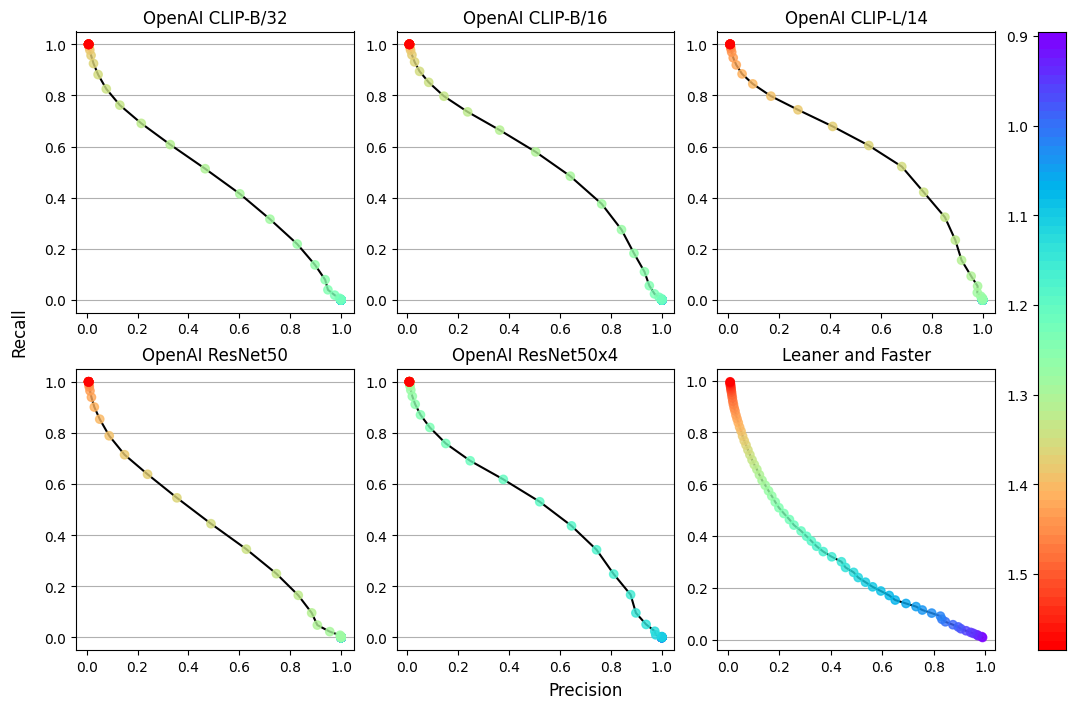

In [34]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

thresholds = torch.arange(0.9, 1.6, 0.01)

fig, axes = plt.subplot_mosaic("ABCD;EFGD", width_ratios=[1, 1, 1, 0.1], figsize=(12, 7.5))
for k, ax in axes.items():
    if k != 'D':
        ax.grid(axis='y')
# fig, axes = plt.subplots(2, 3, figsize=(16, 10), sharey=True, sharex=True)
ax1, ax2, ax3, ax4, ax5, ax6, color_bar_ax = axes['A'], axes['B'], axes['C'], axes['E'], axes['F'], axes['G'], axes['D'], 
# ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
# fig.subplots_adjust(wspace=0.1, hspace=0.1)
colors = np.linspace(0, 1, len(thresholds))
# fig.suptitle("ROC w.r.t Angular distance")

ax1.set_title("OpenAI CLIP-B/32")
ax1.plot(precisions_base_32, recalls_base_32, c='k')
ax1.scatter(precisions_base_32, recalls_base_32, c=colors, cmap='rainbow', label="Thresholds", zorder=10, alpha=0.8)

ax2.set_title("OpenAI CLIP-B/16")
ax2.plot(precisions_base_16, recalls_base_16, c='k')
ax2.scatter(precisions_base_16, recalls_base_16, c=colors, cmap='rainbow', label="Thresholds", zorder=10, alpha=0.8)

ax3.set_title("OpenAI CLIP-L/14")
ax3.plot(precisions_large_14, recalls_large_14, c='k')
ax3.scatter(precisions_large_14, recalls_large_14, c=colors, cmap='rainbow', label="Thresholds", zorder=10, alpha=0.8)

ax4.set_title("OpenAI ResNet50")
ax4.plot(precisions_resnet50, recalls_resnet50, c='k')
ax4.scatter(precisions_resnet50, recalls_resnet50, c=colors, cmap='rainbow', label="Thresholds", zorder=10, alpha=0.8)

ax5.set_title("OpenAI ResNet50x4")
ax5.plot(precisions_resnet50x4, recalls_resnet50x4, c='k')
ax5.scatter(precisions_resnet50x4, recalls_resnet50x4, c=colors, cmap='rainbow', label="Thresholds", zorder=10, alpha=0.8)

ax6.set_title("Leaner and Faster")
ax6.plot(precisions, recalls, c='k')
ax6.scatter(precisions, recalls, c=colors, cmap='rainbow', label="Thresholds", zorder=10, alpha=0.8)

# ax1.set_ylabel("Recall")
# ax4.set_xlabel("Precision")
# ax4.set_ylabel("Recall")
fig.supxlabel("Precision")
fig.supylabel("Recall")
fig.subplots_adjust(left=0.075, bottom=0.075, top=0.9)


# ax2.plot(precisions, false_pos_rate, c='k')
# ax2.scatter(precisions, false_pos_rate, c=colors, cmap='rainbow', label="Thresholds")
# ax2.set_xlabel("Precision")
# ax2.set_ylabel("False positive rate")
# ax2.set_title("Precision vs False positive rate")
# ax2.legend()

color_bar_ax.imshow(colors.reshape(-1, 1), cmap='rainbow', aspect='auto')
color_bar_ax.set_xticks([])
color_bar_ax.set_yticks(colors[::10] * 70)
color_bar_ax.set_yticklabels(thresholds.numpy().round(2)[::10])

# fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=thresholds[0], vmax=thresholds[-1]), cmap='rainbow'), ax=color_bar_ax)
fig.savefig("../assets/images/roc.png")


In [105]:
colors

array([0.        , 0.01449275, 0.02898551, 0.04347826, 0.05797101,
       0.07246377, 0.08695652, 0.10144928, 0.11594203, 0.13043478,
       0.14492754, 0.15942029, 0.17391304, 0.1884058 , 0.20289855,
       0.2173913 , 0.23188406, 0.24637681, 0.26086957, 0.27536232,
       0.28985507, 0.30434783, 0.31884058, 0.33333333, 0.34782609,
       0.36231884, 0.37681159, 0.39130435, 0.4057971 , 0.42028986,
       0.43478261, 0.44927536, 0.46376812, 0.47826087, 0.49275362,
       0.50724638, 0.52173913, 0.53623188, 0.55072464, 0.56521739,
       0.57971014, 0.5942029 , 0.60869565, 0.62318841, 0.63768116,
       0.65217391, 0.66666667, 0.68115942, 0.69565217, 0.71014493,
       0.72463768, 0.73913043, 0.75362319, 0.76811594, 0.7826087 ,
       0.79710145, 0.8115942 , 0.82608696, 0.84057971, 0.85507246,
       0.86956522, 0.88405797, 0.89855072, 0.91304348, 0.92753623,
       0.94202899, 0.95652174, 0.97101449, 0.98550725, 1.        ])

In [ ]:
auc_roc = np.trapz(precisions, recalls)
auc_roc_base_32 = np.trapz(precisions_base_32, recalls_base_32)
auc_roc_large_14 = np.trapz(precisions_large_14, recalls_large_14)
auc_roc_resnet50 = np.trapz(precisions_resnet50, recalls_resnet50)
auc_roc_base_16 = np.trapz(precisions_base_16, recalls_base_16)
auc_roc_resnet50x4 = np.trapz(precisions_resnet50x4, recalls_resnet50x4)
auc_roc, auc_roc_base_32, auc_roc_large_14, auc_roc_resnet50, auc_roc_base_16, auc_roc_resnet50x4

(0.3009978389600656,
 0.4778084549171173,
 0.5840174468927913,
 0.43799321946192965,
 0.5442578151271866,
 0.5052544603314384)

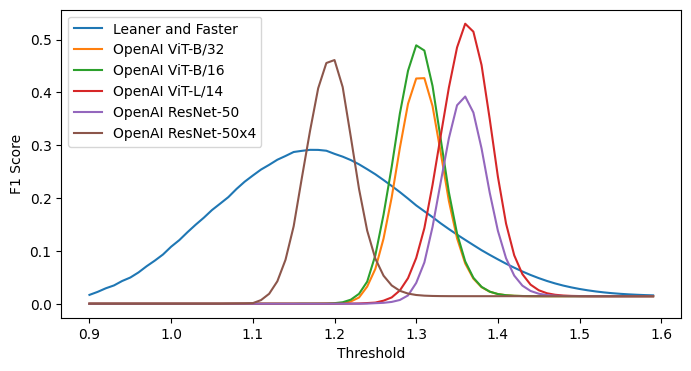

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(thresholds, f1s, label="Leaner and Faster")
ax.plot(thresholds, f1s_base_32, label="OpenAI ViT-B/32")
ax.plot(thresholds, f1s_base_16, label="OpenAI ViT-B/16")
ax.plot(thresholds, f1s_large_14, label="OpenAI ViT-L/14")
ax.plot(thresholds, f1s_resnet50, label="OpenAI ResNet-50")
ax.plot(thresholds, f1s_resnet50x4, label="OpenAI ResNet-50x4")
# ax.plot(thresholds, false_pos_rate, label="False positive rate")
ax.set_xlabel("Threshold")
ax.set_ylabel("F1 Score")
ax.legend()

fig.savefig("../assets/images/stats_comparison.png")

plt.show()

In [ ]:
def top1_top5_angular_distances(ang_dists):
    top5_idxs = (-ang_dists).topk(5, dim=1)[1]
    top1_idxs = top5_idxs[:, 0]
    top1_classes = [queries[idx] for idx in top1_idxs]
    top5_classes = list(map(lambda r: [queries[i] for i in r], top5_idxs))
    top1 = sum([1 if top1_classes[i] in correct_classes_imgs[i] or not correct_classes_imgs[i] else 0 for i in range(nimgs)]) / nimgs
    top5 = 0
    for i, r in enumerate(top5_classes):
        if any([cls in correct_classes_imgs[i] for cls in r]) or not correct_classes_imgs[i]:
            top5 += 1
    top5 /= nimgs
    return top1, top5

# top1_top5_angular_distances(angular_distances), top1_top5_angular_distances(angular_distances_resnet50), top1_top5_angular_distances(angular_distances_base_32)
top1_top5_angular_distances(angular_distances_resnet50x4 )

(0.6332504970178926, 0.8203280318091452)

In [196]:
ntrees_res = pickle.load(open("../assets/pickles/querywise_top5_ntrees.pkl", "rb"))

In [197]:
stats = dict(map(lambda x: (x, ntrees_res[x]['stats']), ntrees_res.keys()))
stats

{64: {'total_time': 3.474756666000758,
  'total_load_time': 0.17039566604216816,
  'total_query_time': 3.247000579169253,
  'load_time_per_index': 0.004259891651054204,
  'query_time_per_query': 0.016235002895846264},
 256: {'total_time': 3.7561295830018935,
  'total_load_time': 0.41706982900359435,
  'total_query_time': 3.27847135803313,
  'load_time_per_index': 0.010426745725089859,
  'query_time_per_query': 0.01639235679016565},
 1024: {'total_time': 6.7712785830008215,
  'total_load_time': 1.6974129589798395,
  'total_query_time': 5.00263458090194,
  'load_time_per_index': 0.04243532397449599,
  'query_time_per_query': 0.025013172904509703},
 4096: {'total_time': 18.83493499999895,
  'total_load_time': 6.851427170011448,
  'total_query_time': 11.915029714684351,
  'load_time_per_index': 0.1712856792502862,
  'query_time_per_query': 0.059575148573421756},
 16384: {'total_time': 61.70324491700012,
  'total_load_time': 25.322516081992944,
  'total_query_time': 36.29945414417307,
  'lo

# HNSW

In [501]:
hnsw_stats = pickle.load(open("../assets/pickles/build_stats_faiss_hnsw.pkl", "rb"))['Hnsw']
hnsw_stats

{32: Built indexes of size 20120 (1 indexes)
         Index add time: 9.12724, 0.00045 per image
         Build time: 0.05596, 0.05596 per index
         CPU build time: 0.00751, 9.12724 per index,
 64: Built indexes of size 20120 (1 indexes)
         Index add time: 9.96312, 0.00050 per image
         Build time: 0.06519, 0.06519 per index
         CPU build time: 0.00917, 9.96312 per index,
 128: Built indexes of size 20120 (1 indexes)
         Index add time: 11.08205, 0.00055 per image
         Build time: 0.10564, 0.10564 per index
         CPU build time: 0.01147, 11.08205 per index,
 256: Built indexes of size 20120 (1 indexes)
         Index add time: 10.70596, 0.00053 per image
         Build time: 0.10303, 0.10303 per index
         CPU build time: 0.01382, 10.70596 per index,
 512: Built indexes of size 20120 (1 indexes)
         Index add time: 11.27689, 0.00056 per image
         Build time: 0.18215, 0.18215 per index
         CPU build time: 0.02030, 11.27689 per index,
 

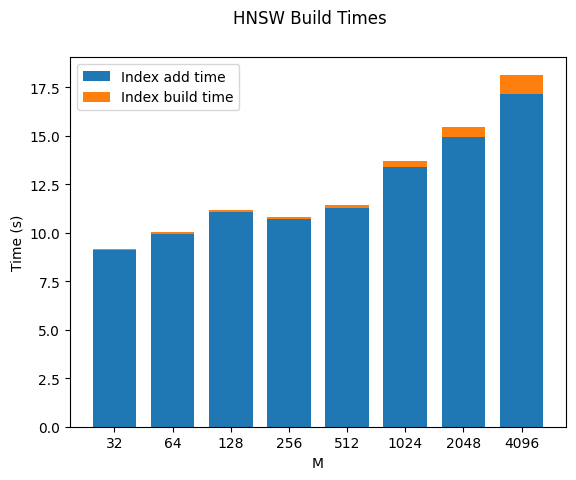

In [503]:
#  {32: Built indexes of size 20120 (1 indexes)
#          Index add time: 9.12724, 0.00045 per image
#          Build time: 0.05596, 0.05596 per index
#          CPU build time: 0.00751, 9.12724 per index,
#  64: Built indexes of size 20120 (1 indexes)
#          Index add time: 9.96312, 0.00050 per image
#          Build time: 0.06519, 0.06519 per index
#          CPU build time: 0.00917, 9.96312 per index,
#  128: Built indexes of size 20120 (1 indexes)
#          Index add time: 11.08205, 0.00055 per image
#          Build time: 0.10564, 0.10564 per index
#          CPU build time: 0.01147, 11.08205 per index,
#  256: Built indexes of size 20120 (1 indexes)
#          Index add time: 10.70596, 0.00053 per image
#          Build time: 0.10303, 0.10303 per index
#          CPU build time: 0.01382, 10.70596 per index,
#  512: Built indexes of size 20120 (1 indexes)
#          Index add time: 11.27689, 0.00056 per image
#          Build time: 0.18215, 0.18215 per index
#          CPU build time: 0.02030, 11.27689 per index,
#  1024: Built indexes of size 20120 (1 indexes)
#          Index add time: 13.41991, 0.00067 per image
#          Build time: 0.28253, 0.28253 per index
#          CPU build time: 0.03558, 13.41991 per index,
#  2048: Built indexes of size 20120 (1 indexes)
#          Index add time: 14.96143, 0.00074 per image
#          Build time: 0.52087, 0.52087 per index
#          CPU build time: 0.06917, 14.96143 per index,
#  4096: Built indexes of size 20120 (1 indexes)
#          Index add time: 17.15021, 0.00085 per image
#          Build time: 1.00802, 1.00802 per index
#          CPU build time: 0.16147, 17.15021 per index}]
Ms = [32, 64, 128, 256, 512, 1024, 2048, 4096]
index_add_times = [9.12724, 9.96312, 11.08205, 10.70596, 11.27689, 13.41991, 14.96143, 17.15021]
index_build_times = [0.05596, 0.06519, 0.10564, 0.10303, 0.18215, 0.28253, 0.52087, 1.00802]
xs = np.arange(len(Ms))

fig, ax = plt.subplots()
fig.suptitle("HNSW Build Times")
ax.bar(xs, index_add_times, label="Index add time", width=0.75)
ax.bar(xs, index_build_times, label="Index build time", width=0.75, bottom=index_add_times)
ax.set_xticks(xs, Ms)
ax.set_xlabel("M")
ax.set_ylabel("Time (s)")
ax.legend()
fig.savefig("../assets/images/faiss_hnsw_build_times.png")
plt.show()

In [236]:
with open("../assets/pickles/querywise_M.pkl", "rb") as f:
    hnsw_max_results = pickle.load(f)
hnsw_max_results = {k: v[k] for k, v in hnsw_max_results.items() if k in hnsw_max_results.keys()}
hnsw_max_results.keys()
hnsw_max_results[8]['stats']

{'total_time': 31.686216333007906,
 'total_load_time': 0.05079458301770501,
 'total_query_time': 0.10216899603256024,
 'load_time_per_index': 0.05079458301770501,
 'query_time_per_query': 0.0005108449801628012}

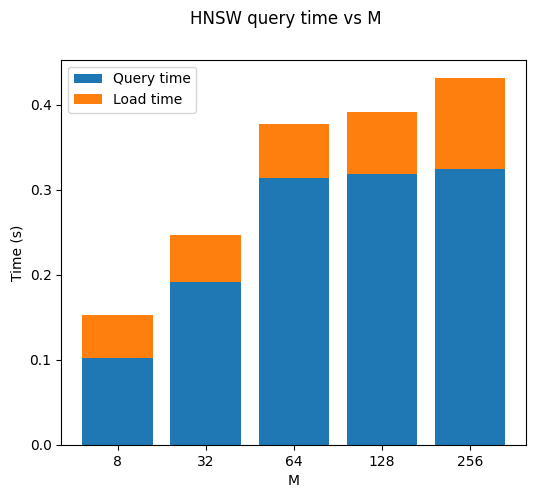

In [244]:
stats = listify_stats(hnsw_max_results)['stats']
x = np.arange(len(Ms))

f = lambda s: np.array(list(map(lambda x: x[s], stats)))

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.bar(x, f('total_query_time'), label='Query time')
ax.set_xticks(x, Ms)

ax.bar(x, f('total_load_time'), bottom=f('total_query_time'), label='Load time')
ax.set_xlabel("M")
ax.set_ylabel("Time (s)")
fig.suptitle("HNSW query time vs M")
plt.legend()
fig.savefig("../assets/images/hnsw_query_time_vs_m.png")
plt.show()

In [271]:
with open("../assets/pickles/querywise_hnsw_max_results.pkl", "rb") as f:
    hnsw_max_results = pickle.load(f)
max_results = [5, 10, 20, 50, 100, 200, 500, 1000]
hnsw_max_results_stats = [hnsw_max_results[k][128]['stats'] for k in max_results]
f = lambda s: np.array(list(map(lambda x: x[s], hnsw_max_results_stats)))
hnsw_max_results_stats

[{'total_time': 2.246029041998554,
  'total_load_time': 0.07681724999565631,
  'total_query_time': 0.09605242102406919,
  'load_time_per_index': 0.07681724999565631,
  'query_time_per_query': 0.00048026210512034593},
 {'total_time': 3.465134375001071,
  'total_load_time': 0.010143249994143844,
  'total_query_time': 0.0833628361870069,
  'load_time_per_index': 0.010143249994143844,
  'query_time_per_query': 0.00041681418093503453},
 {'total_time': 6.639089041011175,
  'total_load_time': 0.010141083010239527,
  'total_query_time': 0.09052400474320166,
  'load_time_per_index': 0.010141083010239527,
  'query_time_per_query': 0.0004526200237160083},
 {'total_time': 16.4938235419977,
  'total_load_time': 0.010257374990032986,
  'total_query_time': 0.10956492007244378,
  'load_time_per_index': 0.010257374990032986,
  'query_time_per_query': 0.000547824600362219},
 {'total_time': 33.9213195409975,
  'total_load_time': 0.010270792001392692,
  'total_query_time': 0.12926849667564966,
  'load_tim

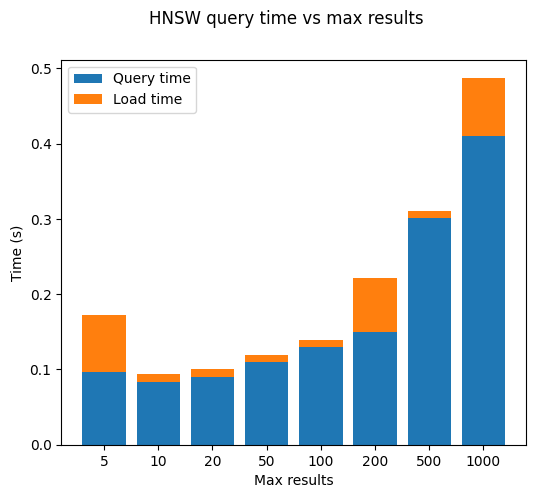

In [274]:
max_results = [5, 10, 20, 50, 100, 200, 500, 1000]
x = np.arange(len(max_results))

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.bar(x, f('total_query_time'), label='Query time')
ax.set_xticks(x, max_results)

ax.bar(x, f('total_load_time'), bottom=f('total_query_time'), label='Load time')
ax.set_xlabel("Max results")
ax.set_ylabel("Time (s)")
fig.suptitle("HNSW query time vs max results")
plt.legend()
fig.savefig("../assets/images/hnsw_query_time_vs_max_results.png")
plt.show()

In [504]:
with open("../assets/pickles/querywise_M_max_results.pkl", "rb") as f:
    hnsw_querywise_data = pickle.load(f)
hnsw_querywise_data = {k: {i: j[k] for i, j in v.items()} for k, v in hnsw_querywise_data.items()}


In [328]:
hnsw_querywise_data.keys(), hnsw_querywise_data[8].keys(), hnsw_querywise_data[8][5].keys()

(dict_keys([8, 32, 64, 128, 256]),
 dict_keys([5, 10, 20, 50, 100, 200, 500, 1000]),
 dict_keys(['data', 'stats']))

[0.041060918068978935,
 0.037139745109016076,
 0.041795616009039804,
 0.05217732922756113,
 0.05956237902864814,
 0.07558490196242929,
 0.08393816440366209,
 0.09241250582272187]

In [339]:
res.keys()

dict_keys([5, 10, 20, 50, 100, 200, 500, 1000])

In [335]:
# {8: {5: {'stats': {'total_query_time': 0.0001,}
total_
for res in [j['stats'] for k, v in hnsw_querywise_data.items() for i, j in v.items()]:
    

[{'total_time': 0.09780812499229796,
  'total_load_time': 0.053107625019038096,
  'total_query_time': 0.041060918068978935,
  'load_time_per_index': 0.053107625019038096,
  'query_time_per_query': 0.00020530459034489467},
 {'total_time': 0.048722334002377465,
  'total_load_time': 0.007964958000229672,
  'total_query_time': 0.037139745109016076,
  'load_time_per_index': 0.007964958000229672,
  'query_time_per_query': 0.00018569872554508038},
 {'total_time': 0.05264612499740906,
  'total_load_time': 0.006782125012250617,
  'total_query_time': 0.041795616009039804,
  'load_time_per_index': 0.006782125012250617,
  'query_time_per_query': 0.00020897808004519903},
 {'total_time': 0.06555395800387487,
  'total_load_time': 0.007305583014385775,
  'total_query_time': 0.05217732922756113,
  'load_time_per_index': 0.007305583014385775,
  'query_time_per_query': 0.00026088664613780564},
 {'total_time': 0.07473420799942687,
  'total_load_time': 0.006533209001645446,
  'total_query_time': 0.05956237

In [464]:
[hnsw_querywise_data[M][5]['stats']['total_load_time'] for M in Ms]

[0.053107625019038096,
 0.05579437501728535,
 0.061257166002178565,
 0.07382645798497833,
 0.10296529199695215]

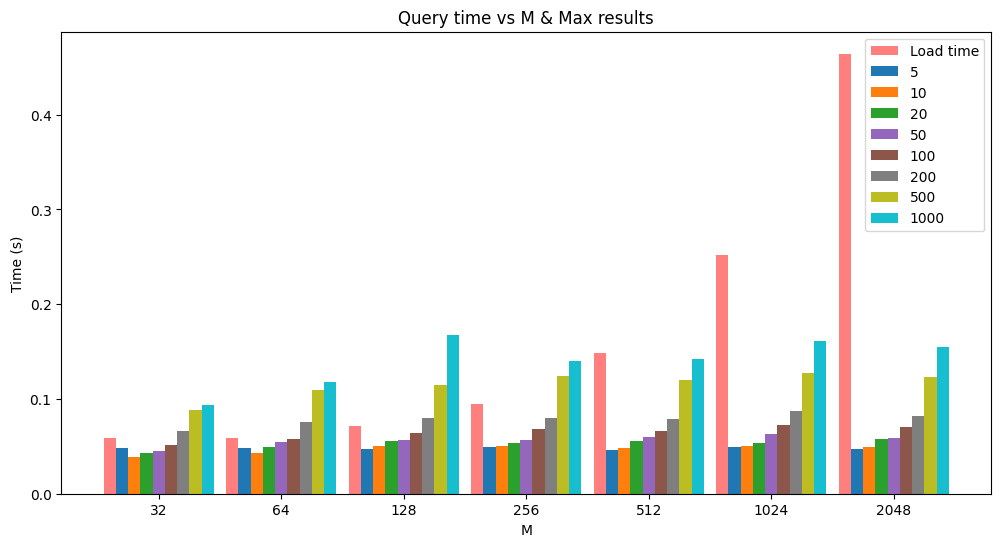

In [511]:
from cycler import cycler
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
Ms = [32, 64, 128, 256, 512, 1024, 2048]
max_results = [5, 10, 20, 50, 100, 200, 500, 1000]

colors = np.linspace(0, 1, len(max_results))
x = np.arange(len(Ms))
max_res_pos = np.linspace(-0.4, 0.4, len(max_results) + 1)
colors_i = np.arange(len(max_results))

ax.bar(np.arange(len(Ms)) + max_res_pos[0], [hnsw_querywise_data[M][5]['stats']['total_load_time'] for M in Ms], width=0.1, color='r', alpha=0.5, label="Load time")

for i, M in enumerate(Ms):
    res = hnsw_querywise_data[M]
    query_times = [ res[x]['stats']['total_query_time'] for x in max_results ] 
    load_times =  [ res[x]['stats']['total_load_time'] for x in max_results ] 
    for j, qt in enumerate(query_times):
        label = None
        if i == 0:
            label = max_results[j]
        ax.bar(i + max_res_pos[j+1], qt, width=0.1, color=cm.tab10(colors[j]), label=label)
    # ax.bar(max_res_pos + i, load_times, bottom=query_times, label="Total Load time", width=0.1, color='orange')
    # ax.bar(x + max_res_pos[i], stats["total_query_time"], width=0.1, label=M)


ax.set_title("Query time vs M & Max results")
ax.set_xticks(x, Ms)
ax.set_xlabel("M")
ax.set_ylabel("Time (s)")
ax.legend()

plt.savefig("../assets/images/hnsw_query_time_max_res_m.png")
# What's interesting is that the max results that is ~= has the longest index time if it is slightly less than the index size.
# This could be because for the max res 500 and index size 512 it still has to do a search, but with max res 1000 and index size 512 it can just return all the results

In [ ]:
# Built indexes of size 20120 (1 indexes)
#         Index add time: 1.06295, 0.00005 per image
#         Build time: 0.05382, 0.05382 per index
#         CPU build time: 0.01086, 1.06295 per index


array([0.        , 0.01449275, 0.02898551, 0.04347826, 0.05797101,
       0.07246377, 0.08695652, 0.10144928, 0.11594203, 0.13043478,
       0.14492754, 0.15942029, 0.17391304, 0.1884058 , 0.20289855,
       0.2173913 , 0.23188406, 0.24637681, 0.26086957, 0.27536232,
       0.28985507, 0.30434783, 0.31884058, 0.33333333, 0.34782609,
       0.36231884, 0.37681159, 0.39130435, 0.4057971 , 0.42028986,
       0.43478261, 0.44927536, 0.46376812, 0.47826087, 0.49275362,
       0.50724638, 0.52173913, 0.53623188, 0.55072464, 0.56521739,
       0.57971014, 0.5942029 , 0.60869565, 0.62318841, 0.63768116,
       0.65217391, 0.66666667, 0.68115942, 0.69565217, 0.71014493,
       0.72463768, 0.73913043, 0.75362319, 0.76811594, 0.7826087 ,
       0.79710145, 0.8115942 , 0.82608696, 0.84057971, 0.85507246,
       0.86956522, 0.88405797, 0.89855072, 0.91304348, 0.92753623,
       0.94202899, 0.95652174, 0.97101449, 0.98550725, 1.        ])

In [506]:
with open("../assets/pickles/imagewise_hnsw_M.pkl", "rb") as f:
    imagewise_hnsw_m = pickle.load(f)


imagewise_hnsw_m = {k: v[k] for k, v in imagewise_hnsw_m.items() if k in imagewise_hnsw_m.keys()}

In [515]:
res_data = {k: v['data'] for k, v in imagewise_hnsw_m.items() if k != 4096}
top1_accuracys, top5_accuracys = get_top1_top5_accuracy(res_data)
top1_accuracys, top5_accuracys, imagewise_hnsw_m.keys()

([0.3250497017892644,
  0.3639165009940358,
  0.3872763419483101,
  0.4064612326043738,
  0.4026341948310139,
  0.4025844930417495,
  0.40238568588469187],
 [0.4162524850894632,
  0.4760437375745527,
  0.5075546719681908,
  0.5319582504970178,
  0.5286779324055666,
  0.5282803180914513,
  0.5292743538767396],
 dict_keys([32, 64, 128, 256, 512, 1024, 2048, 4096]))

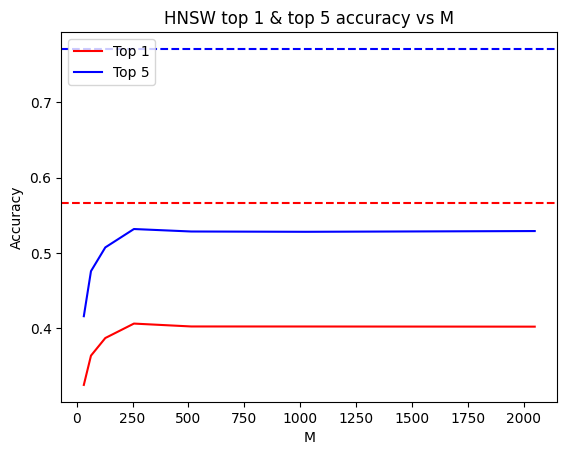

In [567]:
plt.plot(Ms, top1_accuracys, label="Top 1", color='r')
plt.plot(Ms, top5_accuracys, label="Top 5", color='b')
plt.axhline(y=0.566, linestyle='--', color='r')
plt.axhline(y=0.771, linestyle='--', color='b')
plt.xlabel("M")
plt.ylabel("Accuracy")
plt.title("HNSW top 1 & top 5 accuracy vs M")
plt.legend(loc="upper left")
plt.savefig("../assets/images/hnsw_top1_top5_accuracy.png")
# 0.566 0.771
plt.show()

# Other stuff

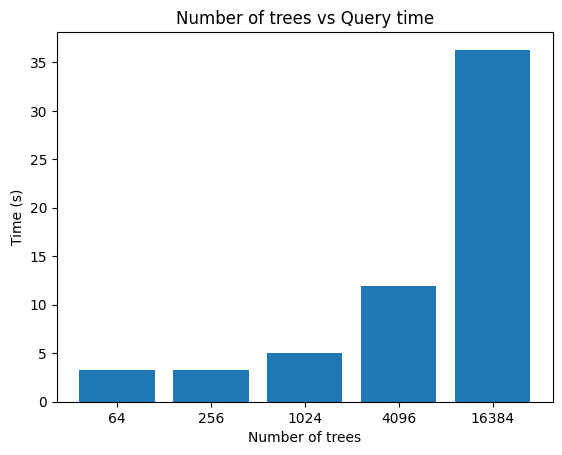

In [202]:
# {64: {'total_time': 3.474756666000758,
#   'total_load_time': 0.17039566604216816,
#   'total_query_time': 3.247000579169253,
#   'load_time_per_index': 0.004259891651054204,
#   'query_time_per_query': 0.016235002895846264},
#  256: {'total_time': 3.7561295830018935,
#   'total_load_time': 0.41706982900359435,
#   'total_query_time': 3.27847135803313,
#   'load_time_per_index': 0.010426745725089859,
#   'query_time_per_query': 0.01639235679016565},
#  1024: {'total_time': 6.7712785830008215,
#   'total_load_time': 1.6974129589798395,
#   'total_query_time': 5.00263458090194,
#   'load_time_per_index': 0.04243532397449599,
#   'query_time_per_query': 0.025013172904509703},
#  4096: {'total_time': 18.83493499999895,
#   'total_load_time': 6.851427170011448,
#   'total_query_time': 11.915029714684351,
#   'load_time_per_index': 0.1712856792502862,
#   'query_time_per_query': 0.059575148573421756},
#  16384: {'total_time': 61.70324491700012,
#   'total_load_time': 25.322516081992944,
#   'total_query_time': 36.29945414417307,
#   'load_time_per_index': 0.6330629020498236,
#   'query_time_per_query': 0.18149727072086536}}
xs = np.arange(len(stats))
f = lambda s: list(map(lambda x: list(stats.values())[x][s], xs))

plt.title("Number of trees vs Query time")
plt.bar(xs, f('total_query_time'))
plt.xticks(xs, list(stats.keys()))
plt.xlabel("Number of trees")
plt.ylabel("Time (s)")
plt.savefig("../assets/images/ntrees_query_time.png")
plt.show()

In [549]:
ntrees_res = pickle.load(open("../assets/pickles/imagewise_top5_ntrees.pkl", "rb"))

In [550]:
all([all([x in j for x in i]) for i, j in zip(ntrees_res[64]['data'], ntrees_res[256]['data'])])

False

In [ ]:
ntrees_res[64], ntrees_res[256]

In [560]:
nr = {0: ntrees_res[1024]}

In [561]:
(
    top_1_ntrees,
    top_5_ntrees,
) = get_top1_top5_accuracy(nr)


top_1_ntrees, top_5_ntrees

([0.40939363817097413], [0.5532803180914513])

In [ ]:
ntrees_res[1024]['data'][8]

[AnnoyImage(query='snowmobile', dist=0.8794094324111938, image_id=9, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00010009.JPEG'), imagenet_classes=None, ref_id=8, index_id=1881),
 AnnoyImage(query='snowplow', dist=1.0213719606399536, image_id=9, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00010009.JPEG'), imagenet_classes=None, ref_id=8, index_id=1881),
 AnnoyImage(query='ski', dist=1.197452187538147, image_id=9, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00010009.JPEG'), imagenet_classes=None, ref_id=8, index_id=1881)]

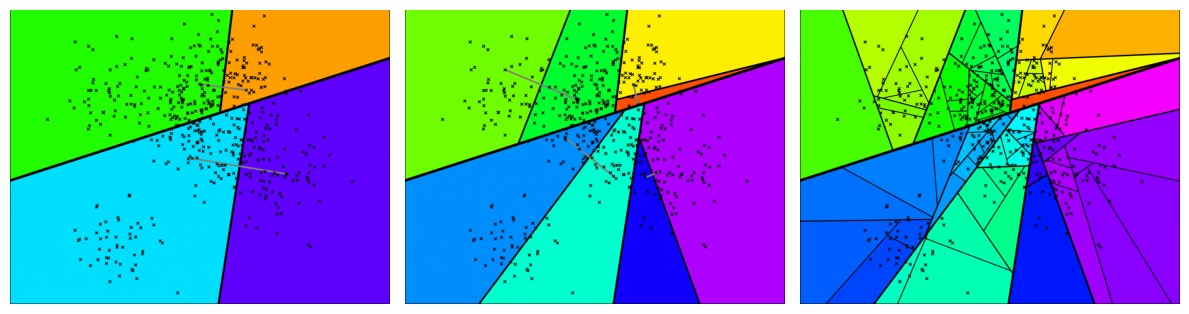

In [ ]:
fig, (ax5, ax1, ax4) = plt.subplots(1, 3, figsize=(12, 4))
ax5.imshow(Image.open("../assets/annoy-tree-2.png"))
ax5.set_axis_off()
ax1.imshow(Image.open("../assets/annoy-tree-3.png"))
ax1.set_axis_off()
ax4.imshow(Image.open("../assets/annoy-tree-4.png"))
ax4.set_axis_off()

plt.tight_layout()
plt.savefig("../assets/images/annoy-trees.png")
plt.show()

In [ ]:
# 8: [AnnoyImage(query='snowmobile', dist=0.8794094324111938, image_id=8, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00010009.JPEG'), imagenet_classes=None, index_id=0, ref_id=8),
#     AnnoyImage(query='snowplow', dist=1.0213719606399536, image_id=8, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00010009.JPEG'), imagenet_classes=None, index_id=0, ref_id=8)],
# 10: AnnoyImage(query='snowplow', dist=1.0213719606399536, image_id=8, image_path=PosixPath('/Volumes/T7/ILSVRC/Data/DET/val/ILSVRC2012_val_00010009.JPEG'), imagenet_classes=None, index_id=0, ref_id=8)],